 # Модуль 6.6: Аналіз Даних з PostgreSQL та Pandas



 Цей notebook демонструє:

 - Підключення до PostgreSQL

 - Завантаження даних у pandas DataFrame

 - Аналіз даних

 - RFM сегментація клієнтів

 - Візуалізація (опціонально)

 ## 1. Підготовка та Підключення

In [4]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Опціонально: візуалізація
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("whitegrid")
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("⚠️  matplotlib не встановлено. Візуалізація недоступна.")


In [5]:
# Конфігурація підключення
DB_CONFIG = {
    'host': 'localhost',
    'port': '5432',
    'database': 'learning_db',
    'user': 'admin',
    'password': 'admin123'
}

# Створити підключення
conn = psycopg2.connect(**DB_CONFIG)
print("✅ Підключення до PostgreSQL успішне!")


✅ Підключення до PostgreSQL успішне!


 ## 2. Завантаження Даних

In [6]:
# Функція для завантаження даних у DataFrame
def load_data(query):
    """Завантажити дані з PostgreSQL у pandas DataFrame"""
    return pd.read_sql_query(query, conn)


In [7]:
# Завантажити основні таблиці
customers_df = load_data("SELECT * FROM customers")
orders_df = load_data("SELECT * FROM orders")
products_df = load_data("SELECT * FROM products")
order_items_df = load_data("SELECT * FROM order_items")

print(f"📊 Завантажено даних:")
print(f"  Клієнтів: {len(customers_df)}")
print(f"  Замовлень: {len(orders_df)}")
print(f"  Товарів: {len(products_df)}")
print(f"  Позицій замовлень: {len(order_items_df)}")


📊 Завантажено даних:
  Клієнтів: 10
  Замовлень: 10
  Товарів: 19
  Позицій замовлень: 22


 ## 3. Базовий Аналіз Даних

In [8]:
# 3.1 Перегляд даних клієнтів
print("👥 Клієнти:")
customers_df.head()


👥 Клієнти:


,id,first_name,last_name,email,phone,city,country,registration_date,is_active,created_at
0,1,Petro,Ivanov,petro.ivanov@gmail.com,+380671234567,Kyiv,Ukraine,2023-01-15,True,2025-10-26 09:01:07.912188
1,2,Anna,Sidorenko,anna.sidorenko@gmail.com,+380672345678,Lviv,Ukraine,2023-02-20,True,2025-10-26 09:01:07.912188
2,3,Maksym,Kovalchuk,maksym.kovalchuk@gmail.com,+380673456789,Kharkiv,Ukraine,2023-03-10,True,2025-10-26 09:01:07.912188
3,4,Iryna,Bondar,iryna.bondar@gmail.com,+380674567890,Odesa,Ukraine,2023-01-25,True,2025-10-26 09:01:07.912188
4,5,Bohdan,Kravets,bohdan.kravets@gmail.com,+380675678901,Dnipro,Ukraine,2023-04-12,True,2025-10-26 09:01:07.912188


In [9]:
# 3.2 Статистика по містах
print("📍 Розподіл клієнтів по містах:")
city_stats = customers_df['city'].value_counts()
print(city_stats)


📍 Розподіл клієнтів по містах:
city
Kyiv            3
Lviv            2
Kharkiv         1
Odesa           1
Dnipro          1
Zaporizhzhia    1
Vinnytsia       1
Name: count, dtype: int64


In [10]:
# 3.3 Аналіз замовлень
print("📦 Статистика замовлень:")
print(f"Загальна кількість: {len(orders_df)}")
print(f"Загальна сума: {orders_df['total_amount'].sum():.2f} грн")
print(f"Середнє замовлення: {orders_df['total_amount'].mean():.2f} грн")
print(f"\nСтатуси замовлень:")
print(orders_df['status'].value_counts())


📦 Статистика замовлень:
Загальна кількість: 10
Загальна сума: 319372.00 грн
Середнє замовлення: 31937.20 грн

Статуси замовлень:
status
delivered     4
processing    3
shipped       2
pending       1
Name: count, dtype: int64


 ## 4. Складний Аналіз з JOIN

In [11]:
# 4.1 Об'єднати дані про клієнтів та їх замовлення
query = """
SELECT
    c.id,
    c.first_name || ' ' || c.last_name AS customer_name,
    c.city,
    c.registration_date,
    COUNT(o.id) AS order_count,
    COALESCE(SUM(o.total_amount), 0) AS total_spent,
    COALESCE(AVG(o.total_amount), 0) AS avg_order_value,
    MAX(o.order_date) AS last_order_date
FROM customers c
LEFT JOIN orders o ON c.id = o.customer_id
GROUP BY c.id, c.first_name, c.last_name, c.city, c.registration_date
"""

customer_analysis = load_data(query)
print("🔍 Аналіз клієнтів:")
customer_analysis.head(10)


🔍 Аналіз клієнтів:


,id,customer_name,city,registration_date,order_count,total_spent,avg_order_value,last_order_date
0,4,Iryna Bondar,Odesa,2023-01-25,1,38798.0,38798.0,2024-10-05 16:45:00
1,10,Halyna Tkach,Vinnytsia,2023-04-30,0,0.0,0.0,NaT
2,6,Olha Rudenko,Kyiv,2023-02-28,1,16498.0,16498.0,2024-10-10 10:00:00
3,2,Anna Sidorenko,Lviv,2023-02-20,1,47997.0,47997.0,2024-10-02 14:20:00
4,9,Vasyl Shevchuk,Kyiv,2023-06-14,1,58998.0,58998.0,2024-10-15 09:20:00
5,7,Taras Melnychuk,Zaporizhzhia,2023-05-05,1,18997.0,18997.0,2024-10-12 15:30:00
6,3,Maksym Kovalchuk,Kharkiv,2023-03-10,1,13296.0,13296.0,2024-10-03 09:15:00
7,1,Petro Ivanov,Kyiv,2023-01-15,2,74095.0,37047.5,2024-10-07 11:30:00
8,5,Bohdan Kravets,Dnipro,2023-04-12,1,16695.0,16695.0,2024-10-08 13:00:00
9,8,Kateryna Polishchuk,Lviv,2023-03-22,1,33998.0,33998.0,2024-10-14 12:45:00


In [12]:
# 4.2 Топ-10 клієнтів за сумою покупок
print("💰 Топ-10 клієнтів:")
top_customers = customer_analysis.nlargest(10, 'total_spent')
top_customers[['customer_name', 'city', 'order_count', 'total_spent']]


💰 Топ-10 клієнтів:


,customer_name,city,order_count,total_spent
7,Petro Ivanov,Kyiv,2,74095.0
4,Vasyl Shevchuk,Kyiv,1,58998.0
3,Anna Sidorenko,Lviv,1,47997.0
0,Iryna Bondar,Odesa,1,38798.0
9,Kateryna Polishchuk,Lviv,1,33998.0
5,Taras Melnychuk,Zaporizhzhia,1,18997.0
8,Bohdan Kravets,Dnipro,1,16695.0
2,Olha Rudenko,Kyiv,1,16498.0
6,Maksym Kovalchuk,Kharkiv,1,13296.0
1,Halyna Tkach,Vinnytsia,0,0.0


 ## 5. RFM Аналіз (Recency, Frequency, Monetary)

In [13]:
# RFM - модель сегментації клієнтів
# R - Recency (як давно купляв)
# F - Frequency (як часто купляє)
# M - Monetary (скільки витрачає)

# Розрахувати RFM метрики
rfm_query = """
SELECT
    c.id,
    c.first_name || ' ' || c.last_name AS customer_name,
    c.email,
    MAX(o.order_date) AS last_order_date,
    COUNT(o.id) AS frequency,
    SUM(o.total_amount) AS monetary,
    CURRENT_DATE - MAX(o.order_date)::DATE AS recency_days
FROM customers c
JOIN orders o ON c.id = o.customer_id
GROUP BY c.id, c.first_name, c.last_name, c.email
"""

rfm_df = load_data(rfm_query)

# Створити RFM оцінки (1-5, де 5 - найкраще)
rfm_df['R_score'] = pd.qcut(rfm_df['recency_days'], 5, labels=[5,4,3,2,1], duplicates='drop')
rfm_df['F_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
rfm_df['M_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')

# Загальний RFM score
rfm_df['RFM_score'] = (rfm_df['R_score'].astype(int) +
                        rfm_df['F_score'].astype(int) +
                        rfm_df['M_score'].astype(int))

# Сегментація клієнтів
def rfm_segment(row):
    if row['RFM_score'] >= 12:
        return 'VIP'
    elif row['RFM_score'] >= 9:
        return 'Loyal'
    elif row['RFM_score'] >= 6:
        return 'Potential'
    else:
        return 'At Risk'

rfm_df['segment'] = rfm_df.apply(rfm_segment, axis=1)

print("🎯 RFM Сегментація:")
print(rfm_df.groupby('segment').size())


🎯 RFM Сегментація:
segment
Loyal        2
Potential    4
VIP          3
dtype: int64


In [14]:
# Детальна інформація по сегментах
print("\n📊 Детальна статистика по сегментах:")
segment_stats = rfm_df.groupby('segment').agg({
    'recency_days': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
segment_stats



📊 Детальна статистика по сегментах:


,recency_days,frequency,monetary
segment,,,
Loyal,381.0,1.00,17846.00
Potential,386.0,1.00,29147.25
VIP,379.0,1.33,55697.00


 ## 6. Аналіз Товарів

In [15]:
# 6.1 Топ товари за виручкою
query = """
SELECT
    p.id,
    p.name,
    p.price,
    COUNT(oi.id) AS times_ordered,
    SUM(oi.quantity) AS total_quantity,
    SUM(oi.subtotal) AS total_revenue
FROM products p
JOIN order_items oi ON p.id = oi.product_id
GROUP BY p.id, p.name, p.price
ORDER BY total_revenue DESC
LIMIT 10
"""

top_products = load_data(query)
print("🏆 Топ-10 товарів за виручкою:")
top_products


🏆 Топ-10 товарів за виручкою:


,id,name,price,times_ordered,total_quantity,total_revenue
0,10,MacBook Air M2,49999.0,1,1,49999.0
1,11,AirPods Pro 2,8999.0,4,5,44995.0
2,2,iPhone 14 Pro,39999.0,1,1,39999.0
3,4,Dell XPS 13,35999.0,1,1,35999.0
4,3,Samsung Galaxy S23,29999.0,1,1,29999.0
5,17,Tablet iPad Air,24999.0,1,1,24999.0
6,1,Laptop HP Pavilion,18999.0,1,1,18999.0
7,16,Smart Watch Garmin,12999.0,1,1,12999.0
8,7,Blender Vitamix,12999.0,1,1,12999.0
9,12,Gaming Chair,5499.0,1,2,10998.0


In [16]:
# 6.2 Аналіз по категоріях
query = """
SELECT
    c.name AS category,
    COUNT(DISTINCT p.id) AS product_count,
    COUNT(oi.id) AS orders_count,
    SUM(oi.subtotal) AS total_revenue,
    AVG(p.price) AS avg_price
FROM categories c
JOIN products p ON c.id = p.category_id
LEFT JOIN order_items oi ON p.id = oi.product_id
GROUP BY c.id, c.name
ORDER BY total_revenue DESC
"""

category_analysis = load_data(query)
print("📦 Аналіз по категоріях:")
category_analysis


📦 Аналіз по категоріях:


,category,product_count,orders_count,total_revenue,avg_price
0,Smartphones,3,6,114993.0,17665.666667
1,Computers,5,6,113894.0,18982.333333
2,Electronics,2,2,37998.0,18999.000000
3,Kitchen,3,4,28996.0,7249.000000
4,Clothing,2,2,11695.0,2449.000000
5,Home & Garden,2,1,10998.0,7749.000000
6,Books,2,1,798.0,429.000000


 ## 7. Часовий Аналіз

In [17]:
# 7.1 Продажі по днях
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])
orders_df['order_day'] = orders_df['order_date'].dt.date

daily_sales = orders_df.groupby('order_day').agg({
    'id': 'count',
    'total_amount': 'sum'
}).rename(columns={'id': 'orders', 'total_amount': 'revenue'})

print("📈 Продажі по днях:")
print(daily_sales)


📈 Продажі по днях:
            orders  revenue
order_day                  
2024-10-01       1  25097.0
2024-10-02       1  47997.0
2024-10-03       1  13296.0
2024-10-05       1  38798.0
2024-10-07       1  48998.0
2024-10-08       1  16695.0
2024-10-10       1  16498.0
2024-10-12       1  18997.0
2024-10-14       1  33998.0
2024-10-15       1  58998.0


In [18]:
# 7.2 Trend аналіз
print(f"\n📊 Загальна статистика:")
print(f"  Середній дохід на день: {daily_sales['revenue'].mean():.2f} грн")
print(f"  Середня кількість замовлень: {daily_sales['orders'].mean():.1f}")
print(f"  Максимальний дохід за день: {daily_sales['revenue'].max():.2f} грн")



📊 Загальна статистика:
  Середній дохід на день: 31937.20 грн
  Середня кількість замовлень: 1.0
  Максимальний дохід за день: 58998.00 грн


 ## 8. Візуалізація (опціонально)

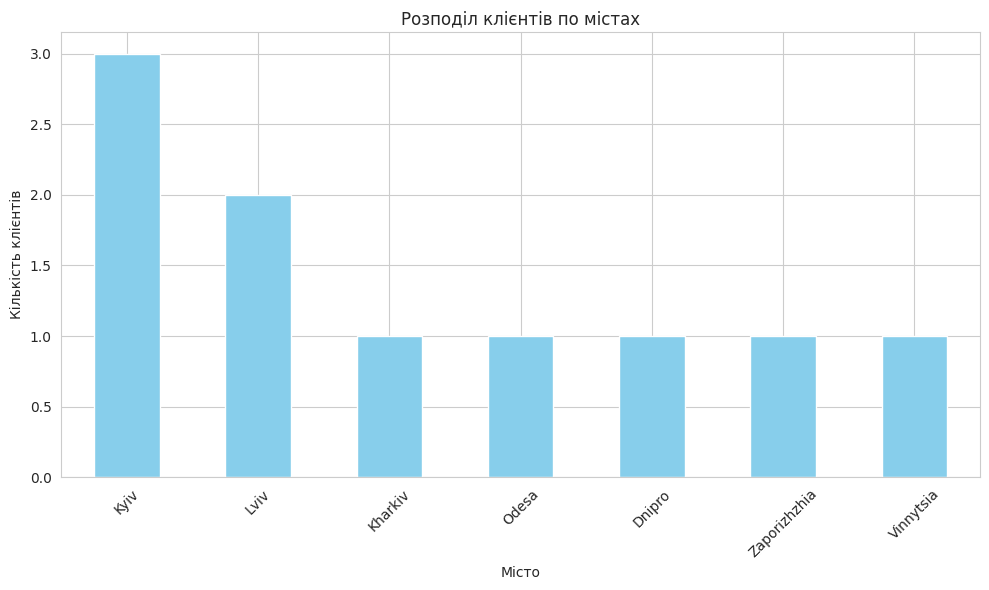

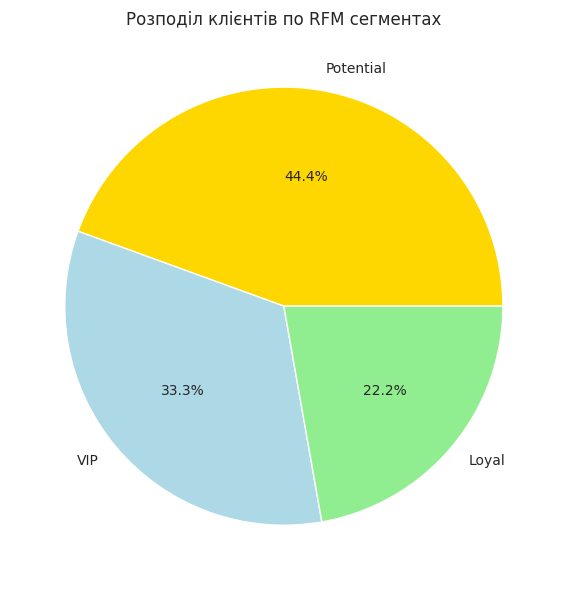

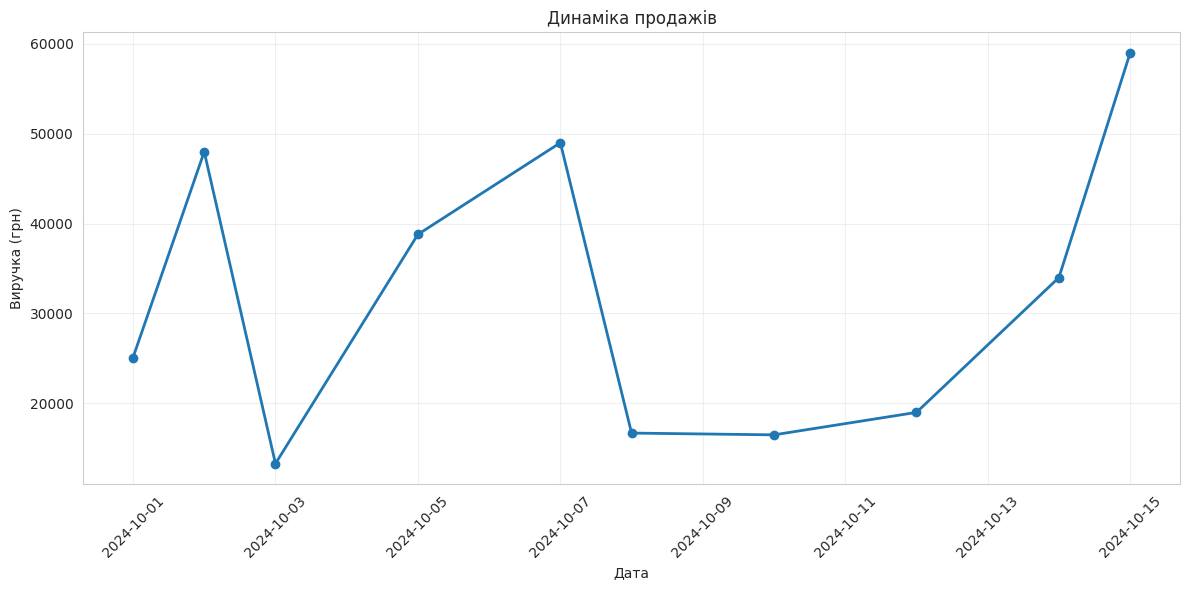

In [19]:
if HAS_MATPLOTLIB:
    # 8.1 Розподіл клієнтів по містах
    plt.figure(figsize=(10, 6))
    city_stats.plot(kind='bar', color='skyblue')
    plt.title('Розподіл клієнтів по містах')
    plt.xlabel('Місто')
    plt.ylabel('Кількість клієнтів')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 8.2 RFM сегменти
    plt.figure(figsize=(8, 6))
    rfm_df['segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['gold', 'lightblue', 'lightgreen', 'salmon'])
    plt.title('Розподіл клієнтів по RFM сегментах')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # 8.3 Продажі по днях
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sales.index, daily_sales['revenue'], marker='o', linewidth=2)
    plt.title('Динаміка продажів')
    plt.xlabel('Дата')
    plt.ylabel('Виручка (грн)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️  Для візуалізації встановіть: pip install matplotlib seaborn")


 ## 9. Експорт Результатів

In [20]:
# Зберегти результати аналізу
rfm_df.to_csv('rfm_analysis.csv', index=False)
print("✅ RFM аналіз збережено у rfm_analysis.csv")

customer_analysis.to_csv('customer_analysis.csv', index=False)
print("✅ Аналіз клієнтів збережено у customer_analysis.csv")


✅ RFM аналіз збережено у rfm_analysis.csv
✅ Аналіз клієнтів збережено у customer_analysis.csv


 ## 10. Підсумок

In [21]:
print("\n" + "="*70)
print("📊 ПІДСУМОК АНАЛІЗУ")
print("="*70)
print(f"\n👥 Клієнти:")
print(f"  Всього: {len(customers_df)}")
print(f"  VIP клієнтів: {len(rfm_df[rfm_df['segment'] == 'VIP'])}")
print(f"  Міст: {customers_df['city'].nunique()}")

print(f"\n📦 Замовлення:")
print(f"  Всього: {len(orders_df)}")
print(f"  Загальна сума: {orders_df['total_amount'].sum():.2f} грн")
print(f"  Середній чек: {orders_df['total_amount'].mean():.2f} грн")

print(f"\n🏆 Топ-3 клієнти:")
for idx, row in top_customers.head(3).iterrows():
    print(f"  {idx+1}. {row['customer_name']}: {row['total_spent']:.2f} грн")

print("\n✅ Аналіз завершено!")



📊 ПІДСУМОК АНАЛІЗУ

👥 Клієнти:
  Всього: 10
  VIP клієнтів: 3
  Міст: 7

📦 Замовлення:
  Всього: 10
  Загальна сума: 319372.00 грн
  Середній чек: 31937.20 грн

🏆 Топ-3 клієнти:
  8. Petro Ivanov: 74095.00 грн
  5. Vasyl Shevchuk: 58998.00 грн
  4. Anna Sidorenko: 47997.00 грн

✅ Аналіз завершено!


In [22]:
# Закрити підключення
conn.close()
print("🔒 Підключення до БД закрито")


🔒 Підключення до БД закрито
